# 2D Fitting example

## Description
Task onsets are 320 and 960 seconds, each with duration of 320 seconds.


In [6]:
from fsl_mrs.utils import mrs_io
import numpy as np

example_data = mrs_io.read_FID('simulated_data_subset/fmrs_bold_3T/sub-001/mrs/sub-001_svs.nii.gz')
print(example_data)
print(example_data.hdr_ext['RepetitionTime'])
print(example_data.hdr_ext['RepetitionTime'] * example_data.shape[example_data.dim_position('DIM_DYN')])


task_onsets = np.array([320, 960]) 
task_durations = np.array([320, 320]) 
print(task_onsets / example_data.hdr_ext['RepetitionTime'])
print(task_durations / example_data.hdr_ext['RepetitionTime'])

This file's header extension is currently invalid. Reason: User-defined key ChemicalShiftOffset does not contain a 'Description' field. Setting empty 'Description'.
File sub-001_svs.nii.gz (/Users/wclarke/Library/CloudStorage/OneDrive-Nexus365/projects/special_issue_fmrs/simulated_data_subset/fmrs_bold_3T/sub-001/mrs)
NIfTI-MRS version 0.2
Data shape (1, 1, 1, 2048, 1, 640)
Dimension tags: ['DIM_COIL', 'DIM_DYN', None]
Spectrometer Frequency: 123.0 MHz
Dwelltime (Spectral bandwidth): 1.667E-04 s (6000 Hz)
Nucleus: 1H
Field Strength: 2.89 T

2.5
1600.0
[128. 384.]
[128. 128.]


In [7]:
example_data.shape[example_data.dim_position('DIM_DYN')] * 2.5

1600.0

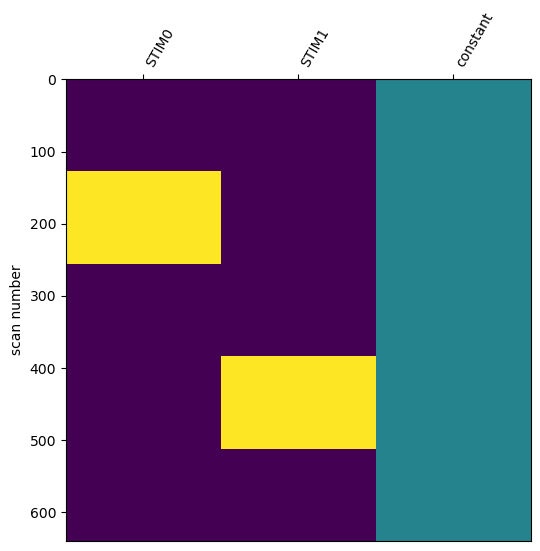

In [8]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Calculations to create the design matrix
tr          = example_data.hdr_ext['RepetitionTime']  # repetition time * number of transients averaged for this demo
n_blocks    = 2  # Number of stimulation blocks
n_scans     = example_data.shape[example_data.dim_position('DIM_DYN')] # Total number of scan points (16)
frame_times = np.arange(n_scans) * tr  # Time point of each data point
conditions  = [f'STIM{i}' for i in range(n_blocks)] # each trial gets its own regressor
duration    = task_durations # Duration of each stimulation block
onsets = task_onsets # Start time of each stimulation block.
events = pd.DataFrame({'trial_type': conditions, 
                       'onset'     : onsets,
                       'duration'  : duration})

# Pass to nilearn function to create design matrix
design_matrix = make_first_level_design_matrix(
    frame_times,
    events,
    drift_model='polynomial',
    drift_order=0, 
    hrf_model=None) 

# Plot the designmatrix for inspection
fig = plt.figure(figsize=(6,6))
_ = plot_design_matrix(design_matrix, axes=fig.gca())

In [16]:
lb_df = pd.read_csv('regressors/lorentz_lb_123_mhz.csv', index_col=0, names=['Lorentz_lb',])
lb_df.index = design_matrix.index
lb_df

,Lorentz_lb
0.0,0.228547
2.5,0.228547
5.0,0.228547
7.5,0.228547
10.0,0.228547
...,...
1587.5,0.228547
1590.0,0.228547
1592.5,0.228547
1595.0,0.228547


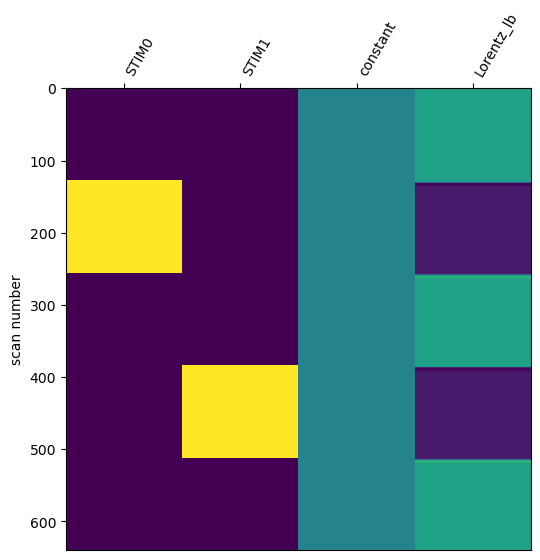

In [18]:
design_matrix_with_lb = pd.concat((design_matrix, lb_df),axis=1)

fig = plt.figure(figsize=(6,6))
_ = plot_design_matrix(design_matrix_with_lb, axes=fig.gca())

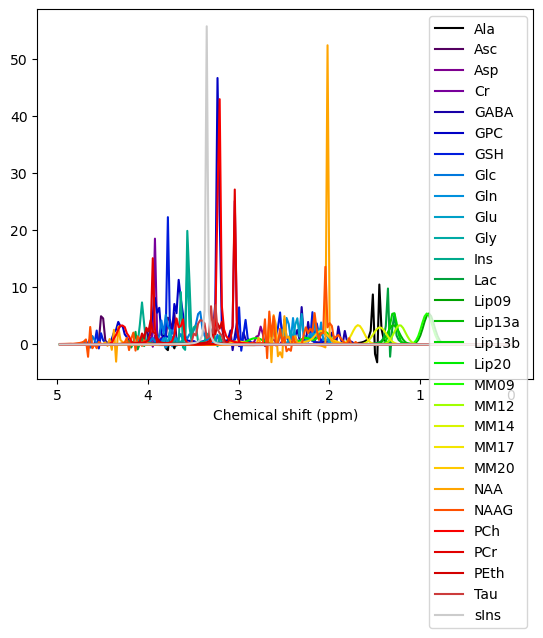

In [32]:
basis = mrs_io.read_basis('basis_sets/slaser_123_mhz.basis')
basis._raw_fids = np.pad(basis.original_basis_array,((0,1), (0,0)))
_ = basis.plot(ppmlim=(0, 5))

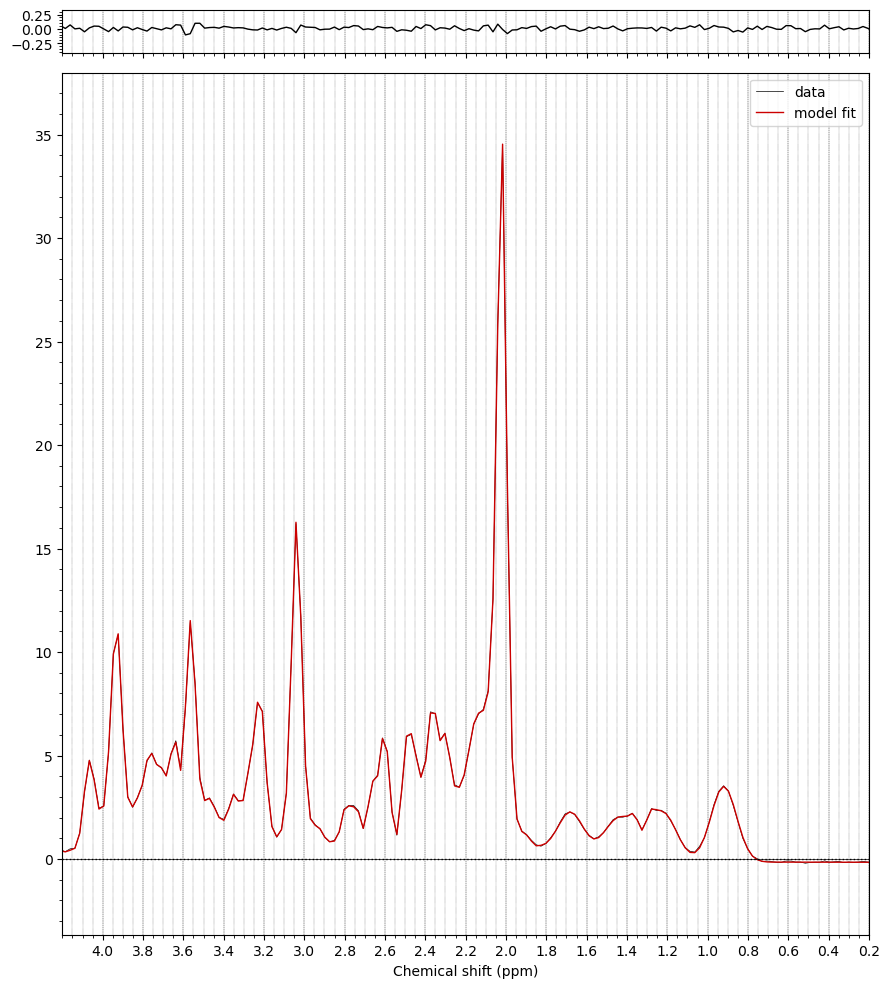

In [36]:
from fsl_mrs.utils.preproc import nifti_mrs_proc as nproc

avg = nproc.average(example_data, 'DIM_DYN')
avg_mrs = avg.mrs(basis=basis)
avg_mrs.processForFitting()
# _ = avg_mrs.plot_basis(add_spec=True)
avg_res = avg_mrs.fit(baseline='off')
_ = avg_res.plot(avg_mrs)

In [38]:
%%writefile dyn_models/fixed_lb.py

# Parameter - functional relationships
Parameters = {
'conc'     : {'dynamic':'model_glm','params':['STIM0', 'STIM1', 'constant']},
'gamma'    : 'fixed',
'sigma'    : 'fixed',
'eps'      : 'fixed',
'baseline' : 'fixed',
'Phi_0'    : 'fixed',
'Phi_1'    : 'fixed'
}

# Bounds on free fitted parameters
Bounds = {
'gamma' : (0,None),
'sigma' : (0,None),
'constant' : (0,None),
}

# Dynamic models
from numpy import dot
def model_glm(p,t):
    return dot(t,p)

# Dynamic model gradients
def model_glm_grad(p,t):
    return t.T

Writing dyn_models/fixed_lb.py


In [39]:
from fsl_mrs.dynamic import dynMRS

dyn_fixed_lb = dynMRS(
    example_data.mrs(basis=basis),
    design_matrix.to_numpy(),
    'dyn_models/fixed_lb.py',
    baseline='off'
)

dyn_res_fixed_lb = dyn_fixed_lb.fit()

In [42]:
init = dyn_fixed_lb.initialise(verbose=True)

Init done in 406.3457179069519 seconds.


In [43]:
dyn_res_fixed_lb2 = dyn_fixed_lb.fit(init=init, verbose=True)

Start fitting
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.4796301278166578
        x: [-2.007e-03 -1.008e-03 ...  5.233e-02  9.390e-03]
      nit: 298
      jac: [ 5.294e-04  1.173e-04 ...  1.485e-03  4.113e-04]
     nfev: 324
     njev: 324
 hess_inv: <94x94 LbfgsInvHessProduct with dtype=float64>
...completed in 987.80335688591 seconds.
Collect results
...completed in 81.73268604278564 seconds.


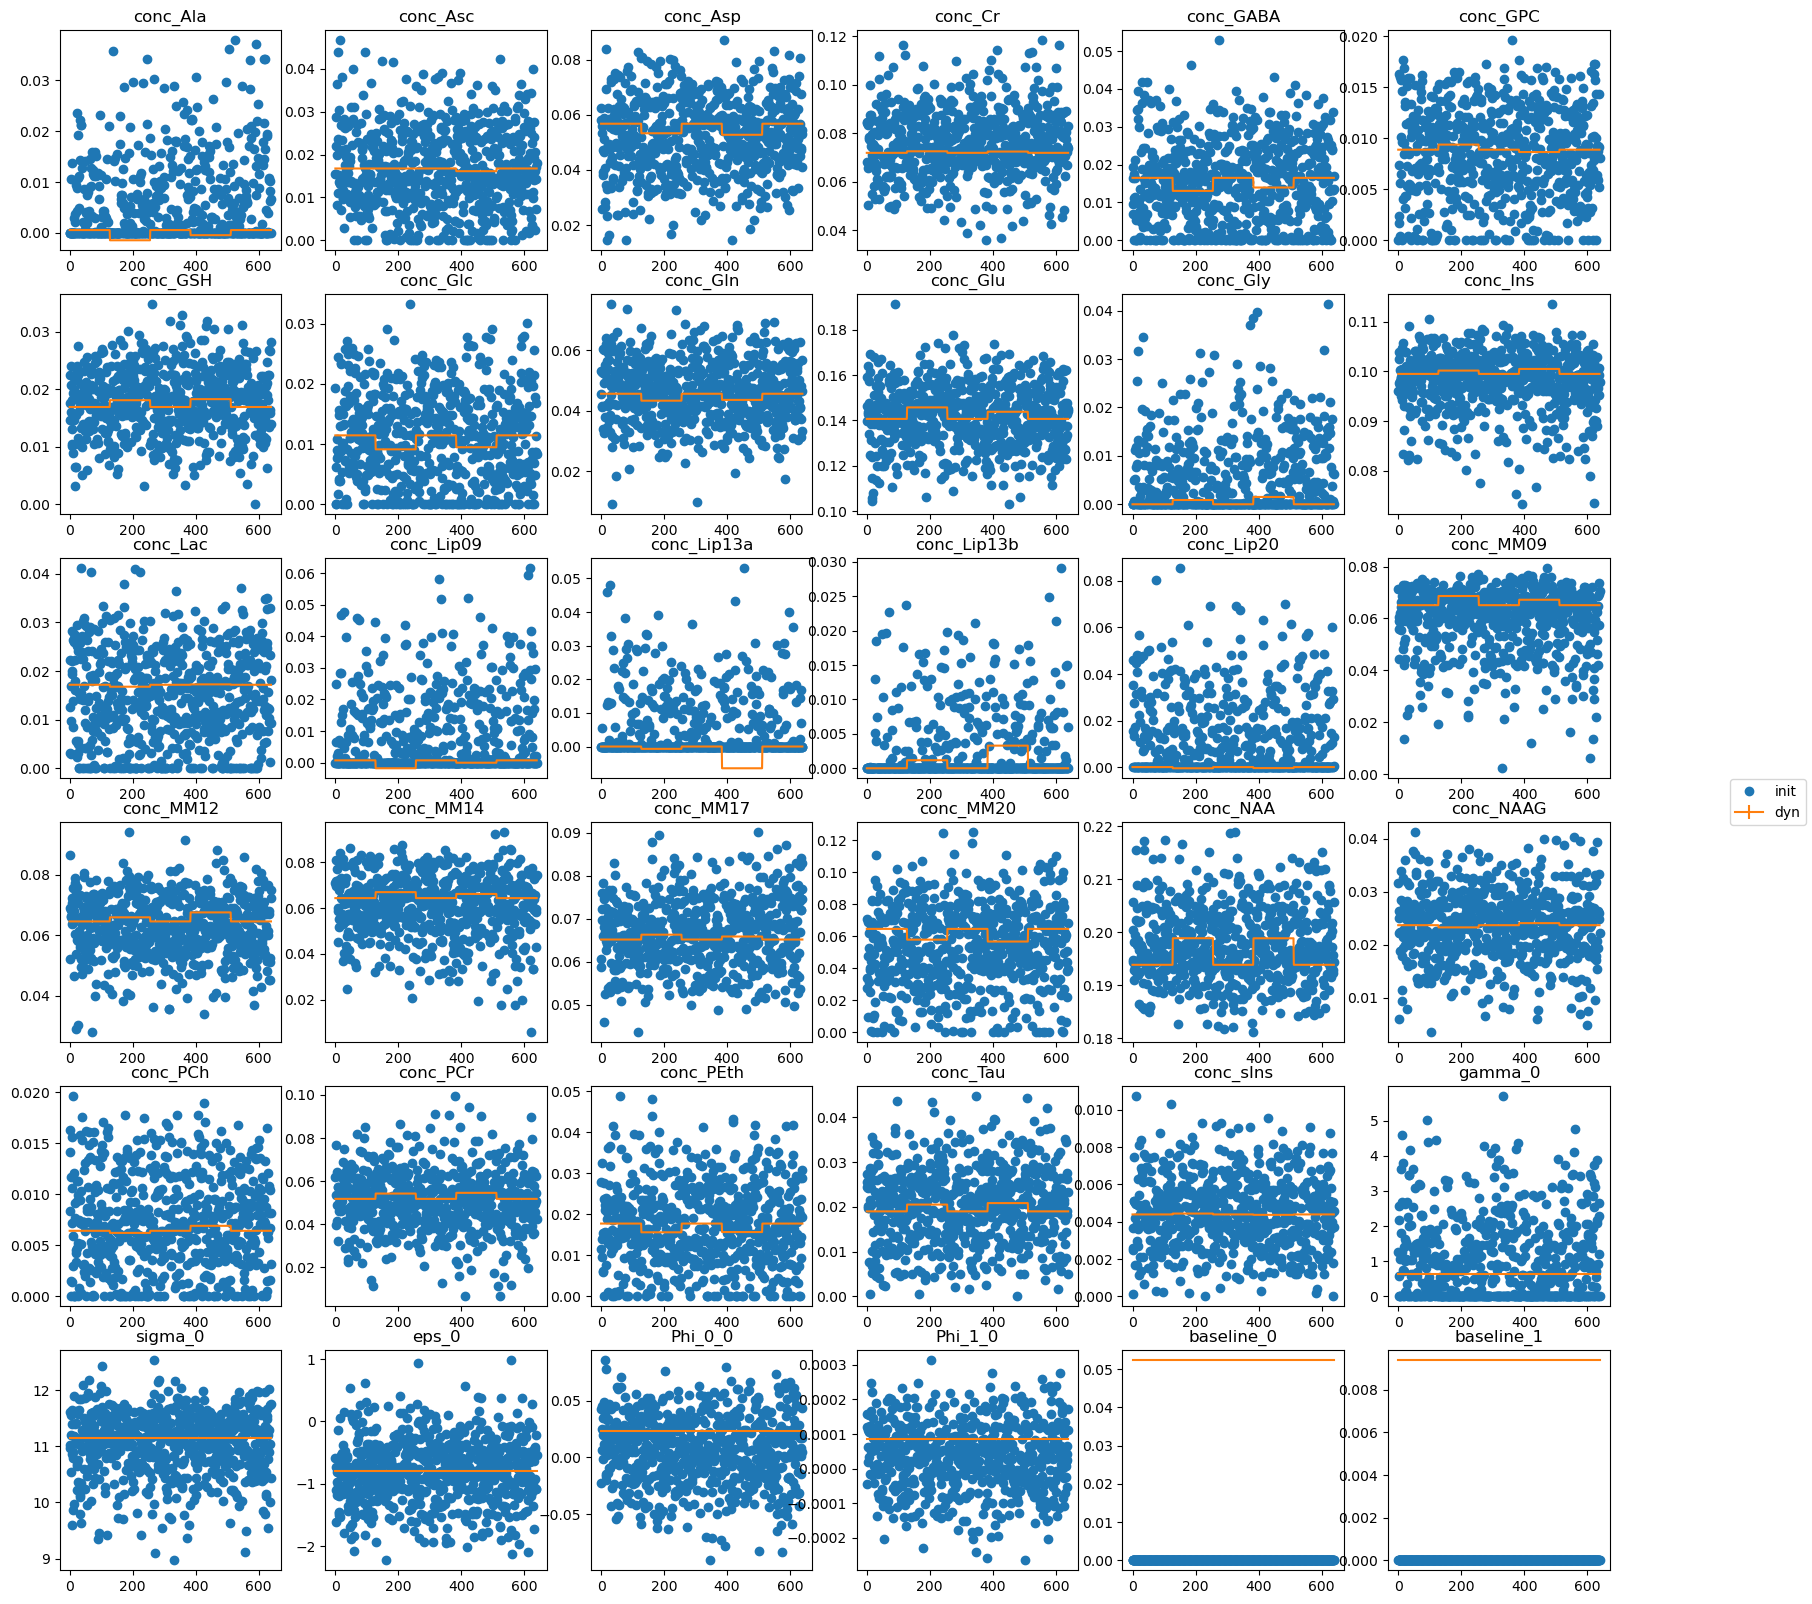

In [44]:
_ = dyn_res_fixed_lb2.plot_mapped()

In [50]:
%%writefile dyn_models/exact_lb.py

# Parameter - functional relationships
Parameters = {
'conc'     : {'dynamic':'model_glm1','params':['STIM0', 'STIM1', 'constant']},
'gamma'    : {'dynamic':'model_glm2','params':['constant', 'Lorentz_lb']},
'sigma'    : 'fixed',
'eps'      : 'fixed',
'baseline' : 'fixed',
'Phi_0'    : 'fixed',
'Phi_1'    : 'fixed'
}

# Bounds on free fitted parameters
Bounds = {
'sigma' : (0,None),
'constant' : (0,None),
}

# Dynamic models
from numpy import dot
def model_glm1(p,t):
    return dot(t[:, :3],p)

# Dynamic model gradients
def model_glm1_grad(p,t):
    return t[:, :3].T

def model_glm2(p,t):
    return dot(t[:, -2:],p)

# Dynamic model gradients
def model_glm2_grad(p,t):
    return t[:, -2:].T

Overwriting dyn_models/exact_lb.py


In [51]:
from fsl_mrs.dynamic import dynMRS

dyn_exact_lb = dynMRS(
    example_data.mrs(basis=basis),
    design_matrix_with_lb.to_numpy(),
    'dyn_models/exact_lb.py',
    baseline='off'
)

init_exact_lb = dyn_exact_lb.initialise(verbose=True)

Init done in 285.34422612190247 seconds.


In [52]:
dyn_res_exact_lb = dyn_exact_lb.fit(init=init_exact_lb, verbose=True)

Start fitting
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.4792473420864833
        x: [-2.204e-03 -9.072e-04 ...  3.965e-02  2.911e-03]
      nit: 306
      jac: [ 5.848e-04 -1.363e-04 ...  6.187e-04  9.824e-04]
     nfev: 330
     njev: 330
 hess_inv: <95x95 LbfgsInvHessProduct with dtype=float64>
...completed in 768.95277094841 seconds.
Collect results
...completed in 73.3488039970398 seconds.


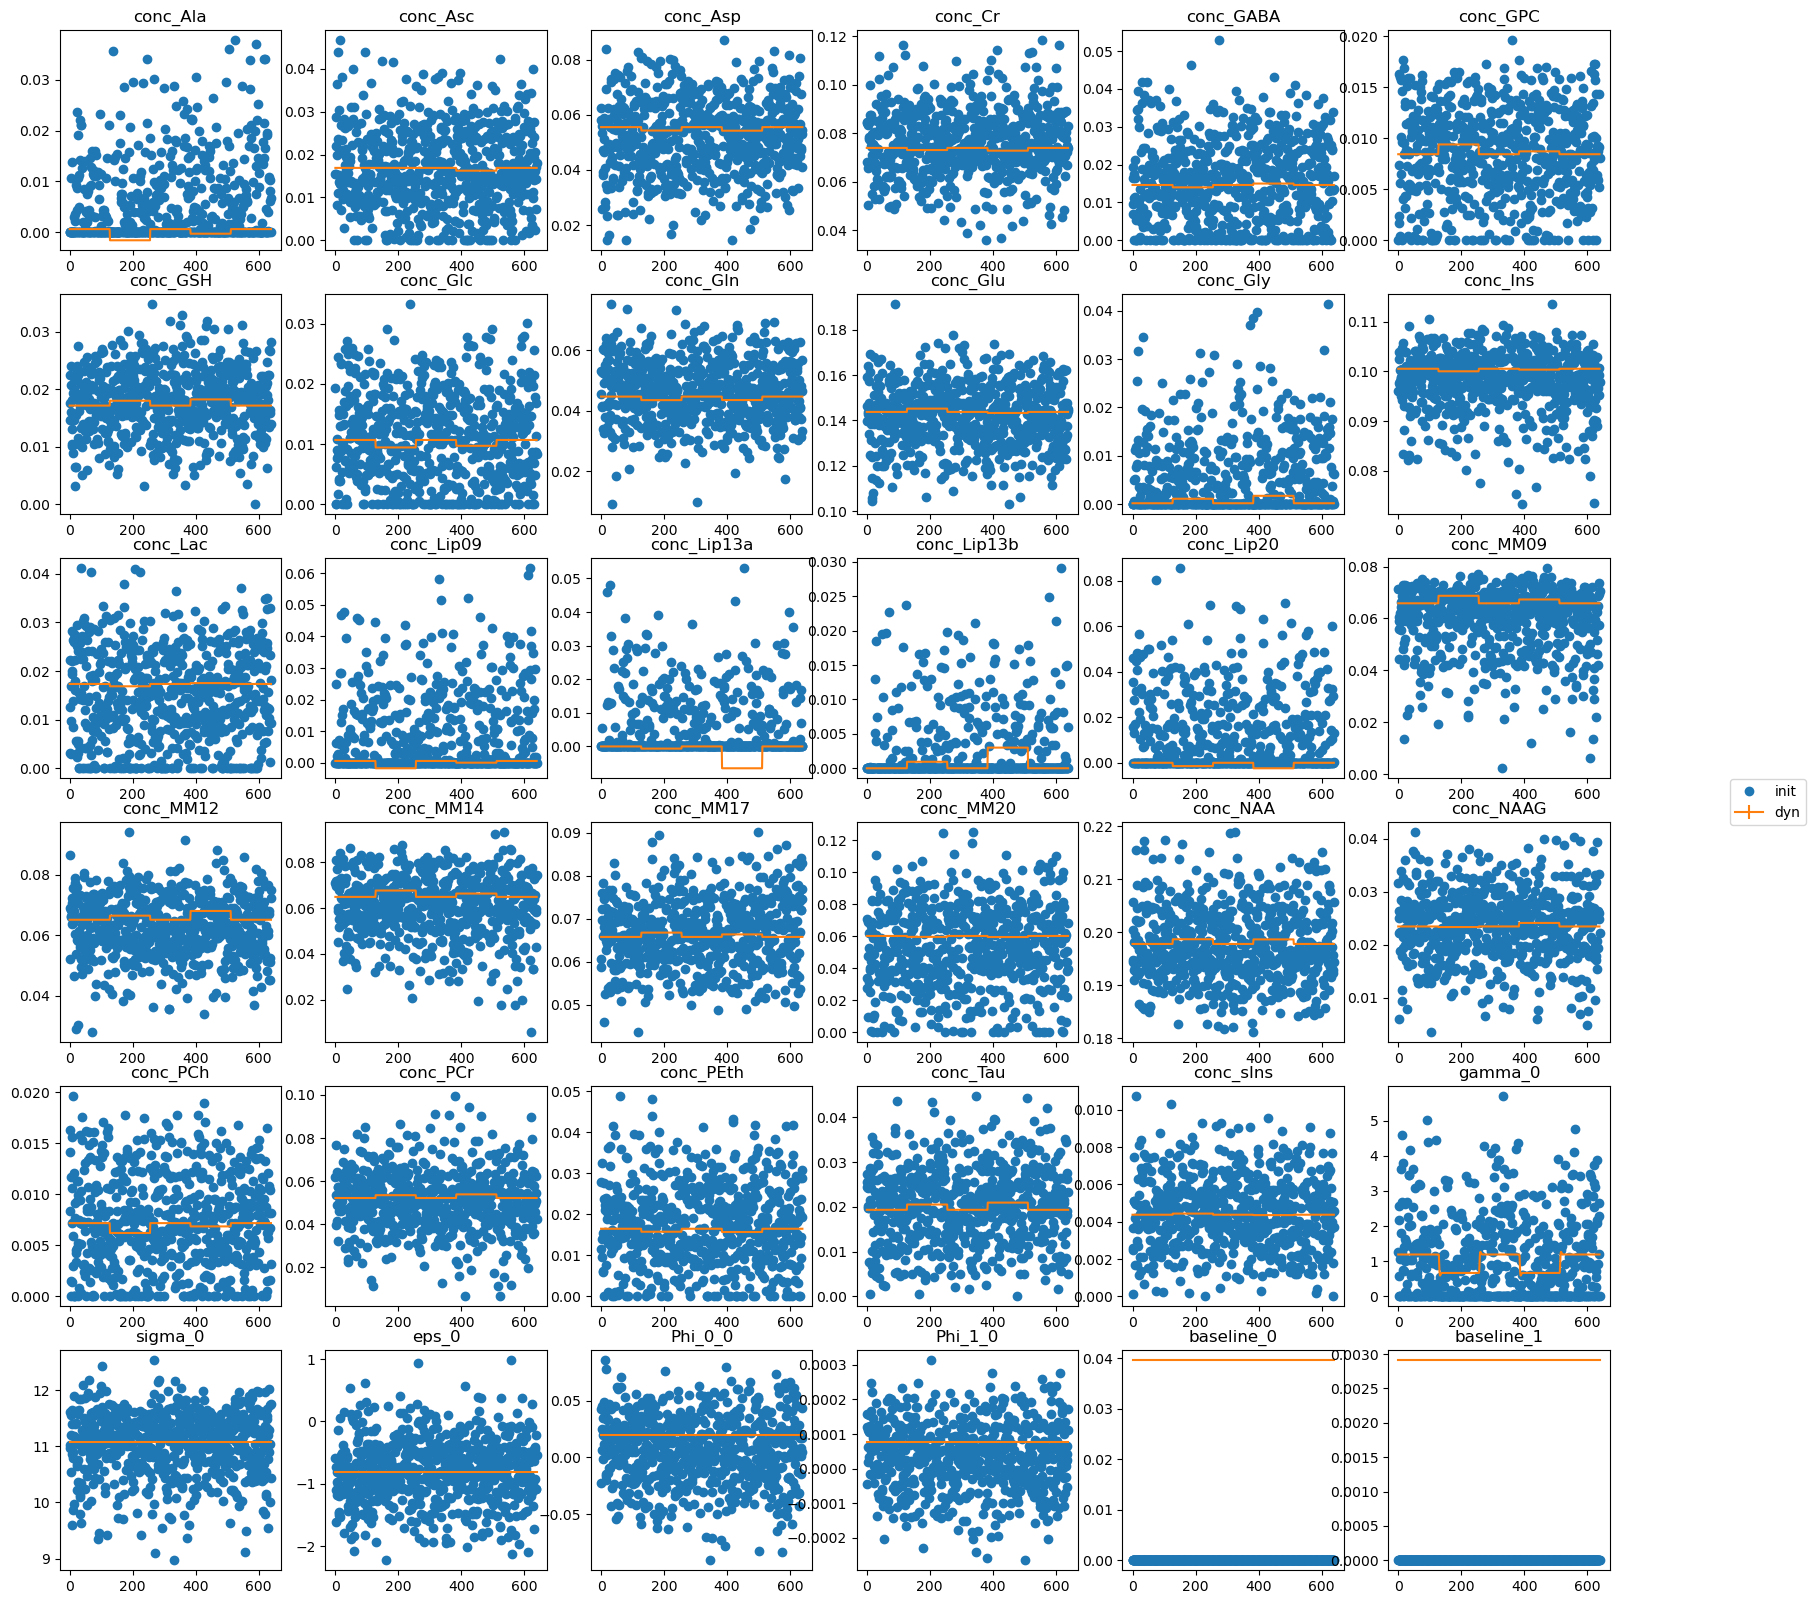

In [54]:
_ = dyn_res_exact_lb.plot_mapped()

### Run on all subjects (3T)

#### Save out basis and design matrices

In [ ]:
basis.save('basis_sets/basis_3t')
design_matrix.to_csv('dyn_models/des_mat_fixed_lb.csv', index=False, header=False)
design_matrix_with_lb.to_csv('dyn_models/des_mat_exact_lb.csv', index=False, header=False)

#### Loop over files running fsl_dynmrs

In [61]:
from pathlib import Path
from subprocess import run
base_data_3t = Path('simulated_data_subset/fmrs_bold_3T')

base_output = Path('./dyn_demo')
base_output.mkdir(exist_ok=True)
(base_output / 'fixed').mkdir(exist_ok=True)
(base_output / 'exact').mkdir(exist_ok=True)

for fp in base_data_3t.rglob('*svs.nii.gz'):
    sub_str = fp.parent.parent.stem
    print(fp)
    print(sub_str)

    #Run fixed lb
    run([
        'fsl_dynmrs',
        '--data', fp,
        '--basis', 'basis_sets/basis_3t',
        '--dyn_config', 'dyn_models/fixed_lb.py',
        '--time_variables', 'dyn_models/des_mat_fixed_lb.csv',
        '--baseline', 'off',
        '--output', base_output / 'fixed' / sub_str,
        '--report',
        '--overwrite'])
    
    #Run exact lb
    run([
        'fsl_dynmrs',
        '--data', fp,
        '--basis', 'basis_sets/basis_3t',
        '--dyn_config', 'dyn_models/exact_lb.py',
        '--time_variables', 'dyn_models/des_mat_exact_lb.csv',
        '--baseline', 'off',
        '--output', base_output / 'exact' / sub_str,
        '--report',
        '--overwrite'])


simulated_data_subset/fmrs_bold_3T/sub-001/mrs/sub-001_svs.nii.gz
sub-001
This file's header extension is currently invalid. Reason: User-defined key ChemicalShiftOffset does not contain a 'Description' field. Setting empty 'Description'.
This file's header extension is currently invalid. Reason: User-defined key ChemicalShiftOffset does not contain a 'Description' field. Setting empty 'Description'.
simulated_data_subset/fmrs_bold_3T/sub-003/mrs/sub-003_svs.nii.gz
sub-003
This file's header extension is currently invalid. Reason: User-defined key ChemicalShiftOffset does not contain a 'Description' field. Setting empty 'Description'.
This file's header extension is currently invalid. Reason: User-defined key ChemicalShiftOffset does not contain a 'Description' field. Setting empty 'Description'.
simulated_data_subset/fmrs_bold_3T/sub-004/mrs/sub-004_svs.nii.gz
sub-004
This file's header extension is currently invalid. Reason: User-defined key ChemicalShiftOffset does not contain a 'De

### Second level

In [62]:
%%writefile dyn_second_level/fl_contrasts.json
[
        {
            "name": "mean_activation",
            "betas": ["STIM0", "STIM1"],
            "scale": [0.5, 0.5]
        }
]

Writing dyn_second_level/fl_contrasts.json


In [65]:
import numpy as np
des_mat = np.ones((4,1), int)
print(des_mat)
np.savetxt('dyn_second_level/ttest_design', des_mat)

%sx Text2Vest dyn_second_level/ttest_design dyn_second_level/design.mat

con_mat = np.ones((1,1), int)
print(con_mat)
np.savetxt('dyn_second_level/pttest_contrasts', con_mat)

%sx Text2Vest dyn_second_level/pttest_contrasts dyn_second_level/design.con

[[1]
 [1]
 [1]
 [1]]
[[1]]


[]

In [81]:
with open('dyn_second_level/exact_lb_results.txt', 'w') as fp:
    for res_dir in (base_output / 'exact').rglob('dyn_cov.csv'):
        fp.write(str(res_dir.parent) + '\n')

with open('dyn_second_level/fixed_lb_results.txt', 'w') as fp:
    for res_dir in (base_output / 'fixed').rglob('dyn_cov.csv'):
        fp.write(str(res_dir.parent) + '\n')

In [82]:
run([
    'fmrs_stats',
    '--data', 'dyn_second_level/exact_lb_results.txt',
    '--output', base_output / 'group_exact_lb',
    '--fl-contrasts', 'dyn_second_level/fl_contrasts.json',
    '--combine', 'NAA', 'NAAG',
    '--combine', 'Cr', 'PCr',
    '--combine', 'PCh', 'GPC',
    '--combine', 'Glu', 'Gln',
    '--hl-design', 'dyn_second_level/design.mat',
    '--hl-contrasts', 'dyn_second_level/design.con',
    '--hl-contrast-names', "Group mean",
    '--overwrite'])

run([
    'fmrs_stats',
    '--data', 'dyn_second_level/fixed_lb_results.txt',
    '--output', base_output / 'group_fixed_lb',
    '--fl-contrasts', 'dyn_second_level/fl_contrasts.json',
    '--combine', 'NAA', 'NAAG',
    '--combine', 'Cr', 'PCr',
    '--combine', 'PCh', 'GPC',
    '--combine', 'Glu', 'Gln',
    '--hl-design', 'dyn_second_level/design.mat',
    '--hl-contrasts', 'dyn_second_level/design.con',
    '--hl-contrast-names', "Group mean",
    '--overwrite'])

Contrast mean_activation requires betas ['STIM0', 'STIM1'], but gamma_0 has different betas: ['constant', 'Lorentz_lb']. Skipping gamma_0.
Contrast mean_activation requires betas ['STIM0', 'STIM1'], but gamma_0 has different betas: ['constant', 'Lorentz_lb']. Skipping gamma_0.
Contrast mean_activation requires betas ['STIM0', 'STIM1'], but gamma_0 has different betas: ['constant', 'Lorentz_lb']. Skipping gamma_0.
Contrast mean_activation requires betas ['STIM0', 'STIM1'], but gamma_0 has different betas: ['constant', 'Lorentz_lb']. Skipping gamma_0.


CompletedProcess(args=['fmrs_stats', '--data', 'dyn_second_level/fixed_lb_results.txt', '--output', PosixPath('dyn_demo/group_fixed_lb'), '--fl-contrasts', 'dyn_second_level/fl_contrasts.json', '--combine', 'NAA', 'NAAG', '--combine', 'Cr', 'PCr', '--combine', 'PCh', 'GPC', '--combine', 'Glu', 'Gln', '--hl-design', 'dyn_second_level/design.mat', '--hl-contrasts', 'dyn_second_level/design.con', '--hl-contrast-names', 'Group mean', '--overwrite'], returncode=0)

In [154]:
group_fixed = pd.read_csv(base_output / 'group_fixed_lb' / 'group_stats.csv',index_col=0, header=[0])
group_fixed.filter(regex='mean_activation', axis=0)\
.drop(['conc_NAA_mean_activation',
       'conc_NAAG_mean_activation',
       'conc_Cr_mean_activation',
       'conc_PCr_mean_activation',
       'conc_PCh_mean_activation',
       'conc_GPC_mean_activation'])\
.style\
.format(formatter={'z':    "{:+05.2f}",
                   'p':    "{:05.3f}"})\
.highlight_between(subset=['p'],left=0, right=0.05, props='font-weight:bold;color:#e83e8c')

,COPE,VARCOPE,z,p
conc_Ala_mean_activation,-0.000110,0.000000,-0.14,0.557
conc_Asc_mean_activation,0.000421,0.000000,+0.66,0.254
conc_Asp_mean_activation,-0.001056,0.000002,-0.74,0.769
conc_GABA_mean_activation,-0.003021,0.000000,-2.48,0.993
conc_GSH_mean_activation,0.000515,0.000000,+1.25,0.105
conc_Glc_mean_activation,-0.001694,0.000000,-2.08,0.981
conc_Gln_mean_activation,-0.002213,0.000000,-2.16,0.985
conc_Glu_mean_activation,0.004494,0.000000,+2.70,0.003
conc_Gly_mean_activation,0.000606,0.000000,+0.76,0.224
conc_Ins_mean_activation,0.000951,0.000000,+1.52,0.065


In [101]:
group_exact = pd.read_csv(base_output / 'group_exact_lb' / 'group_stats.csv',index_col=0, header=[0])
group_exact.filter(regex='(mean_activation)|(Lorentz_lb)', axis=0)\
.drop(['conc_NAA_mean_activation',
       'conc_NAAG_mean_activation',
       'conc_Cr_mean_activation',
       'conc_PCr_mean_activation',
       'conc_PCh_mean_activation',
       'conc_GPC_mean_activation'])\
.style\
.format(formatter={('z',):    "{:+05.2f}",
                   ('p',):    "{:05.3f}"})\
.highlight_between(subset=['p'],left=0, right=0.05, props='font-weight:bold;color:#e83e8c')

,COPE,VARCOPE,z,p
gamma_0_Lorentz_lb,2.310532,0.014716,3.601795,0.000158
conc_Ala_mean_activation,0.000012,0.000001,0.015464,0.493831
conc_Asc_mean_activation,0.000328,0.000000,0.521008,0.301181
conc_Asp_mean_activation,-0.000326,0.000001,-0.283656,0.611663
conc_GABA_mean_activation,-0.000425,0.000000,-0.656165,0.744141
conc_GSH_mean_activation,0.000323,0.000000,0.850933,0.197403
conc_Glc_mean_activation,-0.000741,0.000000,-1.199112,0.884758
conc_Gln_mean_activation,-0.000958,0.000000,-1.290986,0.901646
conc_Glu_mean_activation,0.001027,0.000000,1.202832,0.114521
conc_Gly_mean_activation,0.000808,0.000000,0.972524,0.165395


### Calculate (VAR)COPE in %

In [152]:
def print_percentage_activations(df):
    mean_activation_df = df.filter(regex='mean_activation', axis=0)
    mean_activation_df.index = mean_activation_df.index.str.replace('_mean_activation','').str.replace('conc_','')
    mean_activation_df = mean_activation_df.drop(['NAA', 'NAAG', 'Cr', 'PCr', 'PCh', 'GPC'])
    mean_activation_df

    constant_df = df.filter(regex='constant', axis=0)
    constant_df.index = constant_df.index.str.replace('_constant','').str.replace('conc_','')
    constant_df = constant_df.drop(['NAA', 'NAAG', 'Cr', 'PCr', 'PCh', 'GPC'])
    constant_df.COPE

    mean_activation_df
    # constant_df
    mean_activation_df.loc[:, ['COPE', 'VARCOPE']] = mean_activation_df.loc[:, ['COPE', 'VARCOPE']].div(constant_df.COPE, axis=0)

    return mean_activation_df.style\
    .format(formatter={
        'COPE': "{:+0.1%}",
        'VARCOPE': "{:+0.2%}",
        'z': "{:+05.2f}",
        'p': "{:05.3f}"})\
    .highlight_between(subset=['p'],left=0, right=0.05, props='font-weight:bold;color:#e83e8c')

print_percentage_activations(group_fixed)

,COPE,VARCOPE,z,p
Ala,-77.7%,+0.35%,-0.14,0.557
Asc,+2.5%,+0.00%,+0.66,0.254
Asp,-1.9%,+0.00%,-0.74,0.769
GABA,-18.3%,+0.00%,-2.48,0.993
GSH,+3.0%,+0.00%,+1.25,0.105
Glc,-15.7%,+0.00%,-2.08,0.981
Gln,-4.9%,+0.00%,-2.16,0.985
Glu,+3.2%,+0.00%,+2.70,0.003
Gly,+192.6%,+0.15%,+0.76,0.224
Ins,+1.0%,+0.00%,+1.52,0.065


In [153]:
print_percentage_activations(group_exact)

,COPE,VARCOPE,z,p
Ala,+8.6%,+0.36%,+0.02,0.494
Asc,+1.9%,+0.00%,+0.52,0.301
Asp,-0.6%,+0.00%,-0.28,0.612
GABA,-2.9%,+0.00%,-0.66,0.744
GSH,+1.8%,+0.00%,+0.85,0.197
Glc,-7.4%,+0.00%,-1.20,0.885
Gln,-2.2%,+0.00%,-1.29,0.902
Glu,+0.7%,+0.00%,+1.20,0.115
Gly,+129.6%,+0.08%,+0.97,0.165
Ins,-0.2%,+0.00%,-0.44,0.669
